In [1]:
import pandas as pd
df = pd.read_csv('bahrain_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:37.489000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.266000,...,False,Red Bull Racing,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,1.0,False,NaN,False,False
1,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaN,NaN,0 days 00:00:30.916000,0 days 00:00:41.661000,...,False,Red Bull Racing,0 days 01:01:37.489000,2024-03-02 15:05:19.920,1,1.0,False,NaN,False,True
2,0 days 01:04:50.538000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaN,NaN,0 days 00:00:30.999000,0 days 00:00:41.966000,...,False,Red Bull Racing,0 days 01:03:13.785000,2024-03-02 15:06:56.216,1,1.0,False,NaN,False,True
3,0 days 01:06:27.185000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaN,NaN,0 days 00:00:30.931000,0 days 00:00:41.892000,...,False,Red Bull Racing,0 days 01:04:50.538000,2024-03-02 15:08:32.969,1,1.0,False,NaN,False,True
4,0 days 01:08:04.358000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaN,NaN,0 days 00:00:31.255000,0 days 00:00:42.056000,...,False,Red Bull Racing,0 days 01:06:27.185000,2024-03-02 15:10:09.616,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,0 days 02:25:37.835000,SAR,2,0 days 00:01:35.972000,51.0,4.0,NaN,NaN,0 days 00:00:30.781000,0 days 00:00:41.539000,...,True,Williams,0 days 02:24:01.863000,2024-03-02 16:27:44.294,1,20.0,False,NaN,False,True
1125,0 days 02:27:13.822000,SAR,2,0 days 00:01:35.987000,52.0,4.0,NaN,NaN,0 days 00:00:30.775000,0 days 00:00:41.440000,...,True,Williams,0 days 02:25:37.835000,2024-03-02 16:29:20.266,1,20.0,False,NaN,False,True
1126,0 days 02:28:49.910000,SAR,2,0 days 00:01:36.088000,53.0,4.0,NaN,NaN,0 days 00:00:30.798000,0 days 00:00:41.610000,...,True,Williams,0 days 02:27:13.822000,2024-03-02 16:30:56.253,1,20.0,False,NaN,False,True
1127,0 days 02:30:29.524000,SAR,2,0 days 00:01:39.614000,54.0,4.0,NaN,NaN,0 days 00:00:32.179000,0 days 00:00:43.748000,...,True,Williams,0 days 02:28:49.910000,2024-03-02 16:32:32.341,1,20.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 57  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2              16.0          18.666667   
1    ALO              2              16.0          19.000000   
2    BOT              2              13.0          18.666667   
3    GAS              3              13.0          14.000000   
4    HAM              2              13.0          19.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.267857               0.0         0.732143  
1          0.263158               0.0         0.736842  
2          0.214286               0.0         0.785714  
3          0.446429               0.0         0.553571  
4          0.210526               0.0         0.789474  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,15.0,0 days 01:24:47.139000,NaN,SOFT,15.0,1.0
1,ALB,16.0,NaN,0 days 01:25:11.918000,HARD,1.0,2.0
2,ALB,36.0,0 days 01:59:27.973000,NaN,HARD,21.0,2.0
3,ALB,37.0,NaN,0 days 01:59:52.655000,HARD,1.0,3.0
4,ALO,15.0,0 days 01:24:42.030000,NaN,SOFT,18.0,1.0
...,...,...,...,...,...,...,...
81,VER,38.0,NaN,0 days 02:00:12.014000,SOFT,1.0,3.0
82,ZHO,9.0,0 days 01:14:57.559000,NaN,SOFT,9.0,1.0
83,ZHO,10.0,NaN,0 days 01:15:22.700000,HARD,1.0,2.0
84,ZHO,28.0,0 days 01:46:17.855000,NaN,HARD,19.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,16.0,18.666667,0.267857,0.0,0.732143
1,ALO,2,16.0,19.000000,0.263158,0.0,0.736842
2,BOT,2,13.0,18.666667,0.214286,0.0,0.785714
3,GAS,3,13.0,14.000000,0.446429,0.0,0.553571
4,HAM,2,13.0,19.000000,0.210526,0.0,0.789474
5,HUL,3,2.0,14.000000,0.285714,0.0,0.714286
6,LEC,2,12.0,19.000000,0.192982,0.0,0.807018
7,MAG,2,12.0,18.666667,0.196429,0.0,0.803571
8,NOR,2,14.0,19.000000,0.228070,0.0,0.771930
9,OCO,2,11.0,18.666667,0.178571,0.0,0.821429


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1024


In [9]:
df['Driver'].value_counts()


,count
Driver,
VER,52
PER,52
SAI,52
LEC,52
RUS,52
NOR,52
HAM,52
PIA,52
ALO,52


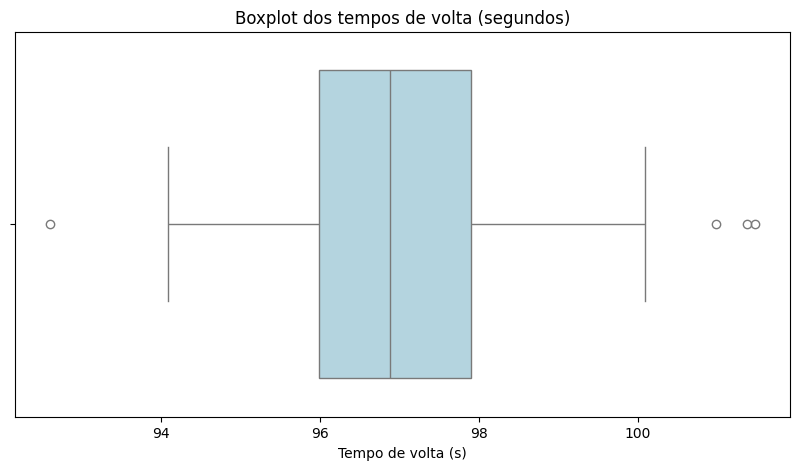

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


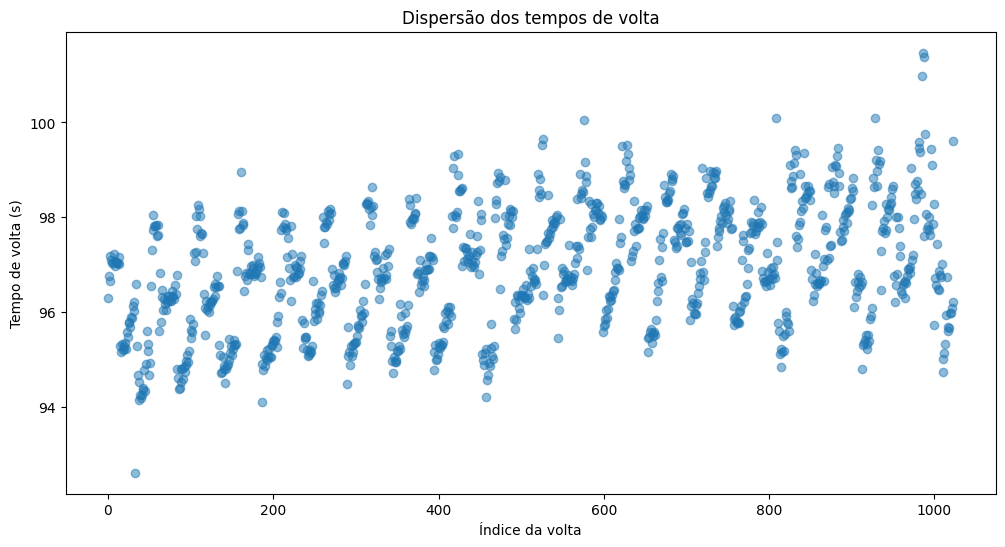

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


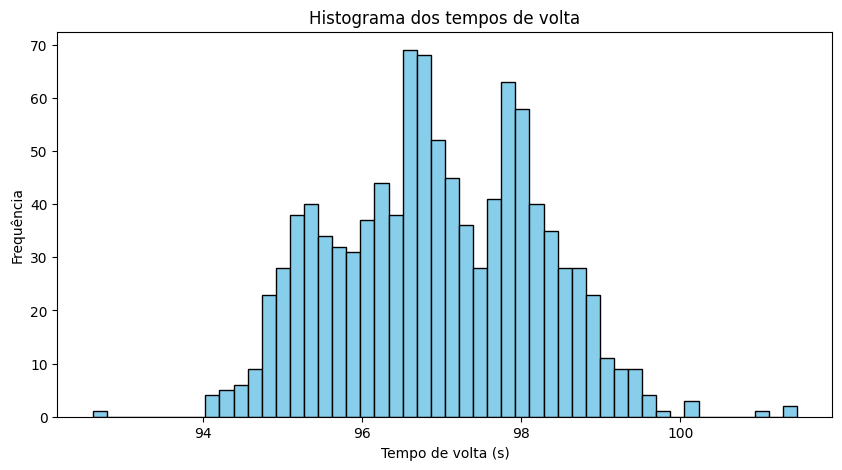

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


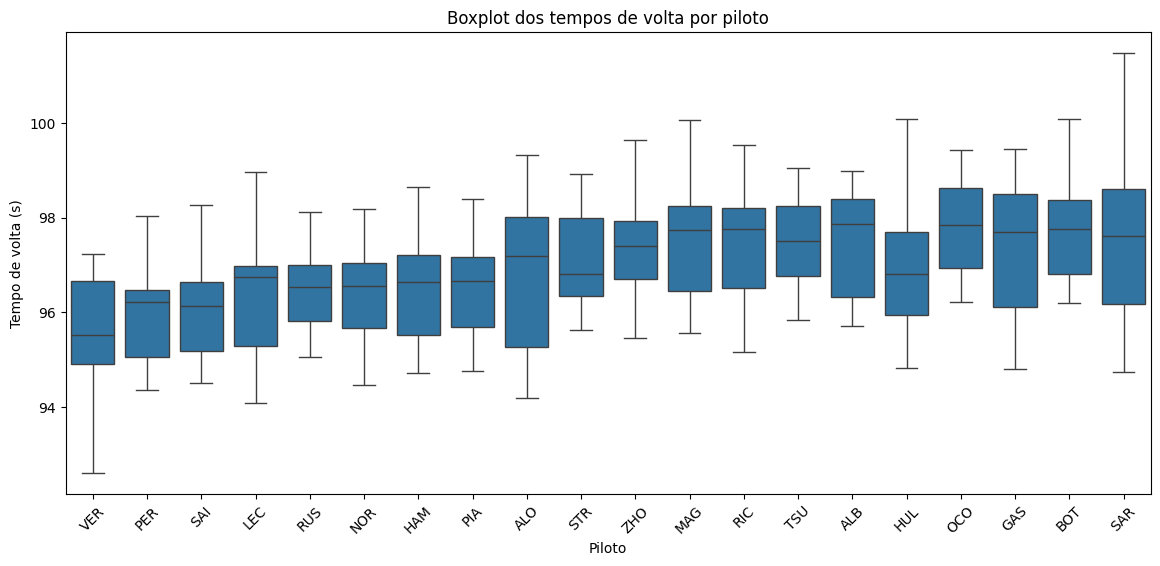

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
VER   0 days 00:01:32.608000
LEC   0 days 00:01:34.090000
ALO   0 days 00:01:34.199000
PER   0 days 00:01:34.364000
NOR   0 days 00:01:34.476000
SAI   0 days 00:01:34.507000
HAM   0 days 00:01:34.722000
SAR   0 days 00:01:34.735000
PIA   0 days 00:01:34.774000
GAS   0 days 00:01:34.805000
HUL   0 days 00:01:34.834000
RUS   0 days 00:01:35.065000
RIC   0 days 00:01:35.163000
ZHO   0 days 00:01:35.458000
MAG   0 days 00:01:35.570000
STR   0 days 00:01:35.632000
ALB   0 days 00:01:35.723000
TSU   0 days 00:01:35.833000
BOT   0 days 00:01:36.202000
OCO   0 days 00:01:36.226000
Name: LapTime, dtype: timedelta64[ns]


In [16]:
year = 2024
grand_prix = 'Bahrein'
race_date = '2024-03-02'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [17]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,51,97.534569,1.093772,95.723,98.977,97.8690,3.254,2024,Bahrein,2024-03-02
1,ALO,52,96.939904,1.405694,94.199,99.325,97.1905,5.126,2024,Bahrein,2024-03-02
2,BOT,51,97.719451,0.973668,96.202,100.087,97.7650,3.885,2024,Bahrein,2024-03-02
3,GAS,49,97.304571,1.355696,94.805,99.452,97.6890,4.647,2024,Bahrein,2024-03-02
4,HAM,52,96.495000,1.133913,94.722,98.645,96.6495,3.923,2024,Bahrein,2024-03-02
5,HUL,50,96.854680,1.067071,94.834,100.083,96.8160,5.249,2024,Bahrein,2024-03-02
6,LEC,52,96.368308,1.122611,94.090,98.957,96.7580,4.867,2024,Bahrein,2024-03-02
7,MAG,51,97.465078,1.064484,95.570,100.058,97.7490,4.488,2024,Bahrein,2024-03-02
8,NOR,52,96.463519,1.006134,94.476,98.172,96.5655,3.696,2024,Bahrein,2024-03-02
9,OCO,51,97.810725,0.934607,96.226,99.422,97.8430,3.196,2024,Bahrein,2024-03-02


In [18]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [19]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,51,97.534569,1.093772,95.723,98.977,97.8690,3.254,2024,Bahrein,2024-03-02,56.0,True
1,ALO,52,96.939904,1.405694,94.199,99.325,97.1905,5.126,2024,Bahrein,2024-03-02,57.0,True
2,BOT,51,97.719451,0.973668,96.202,100.087,97.7650,3.885,2024,Bahrein,2024-03-02,56.0,True
3,GAS,49,97.304571,1.355696,94.805,99.452,97.6890,4.647,2024,Bahrein,2024-03-02,56.0,True
4,HAM,52,96.495000,1.133913,94.722,98.645,96.6495,3.923,2024,Bahrein,2024-03-02,57.0,True
5,HUL,50,96.854680,1.067071,94.834,100.083,96.8160,5.249,2024,Bahrein,2024-03-02,56.0,True
6,LEC,52,96.368308,1.122611,94.090,98.957,96.7580,4.867,2024,Bahrein,2024-03-02,57.0,True
7,MAG,51,97.465078,1.064484,95.570,100.058,97.7490,4.488,2024,Bahrein,2024-03-02,56.0,True
8,NOR,52,96.463519,1.006134,94.476,98.172,96.5655,3.696,2024,Bahrein,2024-03-02,57.0,True
9,OCO,51,97.810725,0.934607,96.226,99.422,97.8430,3.196,2024,Bahrein,2024-03-02,56.0,True


In [20]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,16.0,18.666667,0.267857,0.0,0.732143
1,ALO,2,16.0,19.000000,0.263158,0.0,0.736842
2,BOT,2,13.0,18.666667,0.214286,0.0,0.785714
3,GAS,3,13.0,14.000000,0.446429,0.0,0.553571
4,HAM,2,13.0,19.000000,0.210526,0.0,0.789474
5,HUL,3,2.0,14.000000,0.285714,0.0,0.714286
6,LEC,2,12.0,19.000000,0.192982,0.0,0.807018
7,MAG,2,12.0,18.666667,0.196429,0.0,0.803571
8,NOR,2,14.0,19.000000,0.228070,0.0,0.771930
9,OCO,2,11.0,18.666667,0.178571,0.0,0.821429


In [21]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [22]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,51,97.534569,1.093772,95.723,98.977,97.8690,3.254,2024,Bahrein,2024-03-02,56.0,True,2,16.0,18.666667,0.267857,0.0,0.732143
1,ALO,52,96.939904,1.405694,94.199,99.325,97.1905,5.126,2024,Bahrein,2024-03-02,57.0,True,2,16.0,19.000000,0.263158,0.0,0.736842
2,BOT,51,97.719451,0.973668,96.202,100.087,97.7650,3.885,2024,Bahrein,2024-03-02,56.0,True,2,13.0,18.666667,0.214286,0.0,0.785714
3,GAS,49,97.304571,1.355696,94.805,99.452,97.6890,4.647,2024,Bahrein,2024-03-02,56.0,True,3,13.0,14.000000,0.446429,0.0,0.553571
4,HAM,52,96.495000,1.133913,94.722,98.645,96.6495,3.923,2024,Bahrein,2024-03-02,57.0,True,2,13.0,19.000000,0.210526,0.0,0.789474
5,HUL,50,96.854680,1.067071,94.834,100.083,96.8160,5.249,2024,Bahrein,2024-03-02,56.0,True,3,2.0,14.000000,0.285714,0.0,0.714286
6,LEC,52,96.368308,1.122611,94.090,98.957,96.7580,4.867,2024,Bahrein,2024-03-02,57.0,True,2,12.0,19.000000,0.192982,0.0,0.807018
7,MAG,51,97.465078,1.064484,95.570,100.058,97.7490,4.488,2024,Bahrein,2024-03-02,56.0,True,2,12.0,18.666667,0.196429,0.0,0.803571
8,NOR,52,96.463519,1.006134,94.476,98.172,96.5655,3.696,2024,Bahrein,2024-03-02,57.0,True,2,14.0,19.000000,0.228070,0.0,0.771930
9,OCO,51,97.810725,0.934607,96.226,99.422,97.8430,3.196,2024,Bahrein,2024-03-02,56.0,True,2,11.0,18.666667,0.178571,0.0,0.821429


In [23]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [24]:
df_completo.to_csv('df_completoBahrein.csv', index=False)
